# Character-Level MLP Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

In this notebook we implement a **multilayer perceptron** (MLP) character-level language model. We will improve our previous bigram character-level language model on maximizing the likelihood of a next character by passing embeddings of characters in its context to an MLP network. Instead of learning a large lookup table for each character combination as in the previous notebook, here the embedding vectors are combined to make a prediction, allowing for better generalization with less parameters to learn.

This notebook is based on [this tutorial](https://www.youtube.com/watch?v=TCH_1BHY58I) by [Andrej Karpathy](https://karpathy.ai/) on language modeling. 

In [1]:
import math
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42
DEBUG = True
if DEBUG:
    TRAIN_RATIO = 0.3
else:
    TRAIN_RATIO = 1.0

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

Same **names dataset** as previous notebook:

In [2]:
names = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
names = names[:int(TRAIN_RATIO * len(names))]

print(len(names))
names[:10]

9609


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

We will use the same dataset builder from the previous notebook.

In [3]:
class CharDataset:
    def __init__(self, names, context_size):
        self.names = names
        self.chars = ['.'] + sorted(list(set(''.join(names))))
        self.context_size = context_size
        self.itos = dict(enumerate(self.chars))
        self.stoi = {c: i for i, c in self.itos.items()}

    def decode(self, x):
        return ''.join(self.itos[i] for i in x)

    def encode(self, word):
        return [self.stoi[c] for c in word]

    def build_dataset(self):
        """Creating subsequences -> next character target."""
        xs = []
        ys = []
        for name in self.names:
            context = ['.'] * self.context_size
            for c in name + '.':
                xs.append(self.encode(''.join(context)))
                ys.append(self.stoi[c])
                context = context[1:] + [c]
        return xs, ys

Note that we use a different encoding. Building sequence dataset with block size 3: 

In [4]:
import pandas as pd

BLOCK_SIZE = 3
dataset = CharDataset(names, context_size=BLOCK_SIZE)
itos = dataset.itos
stoi = dataset.stoi

xs, ys = dataset.build_dataset()

df = pd.DataFrame({'xs': xs, 'ys': ys})
df['seq'] = df['xs'].apply(lambda x: ''.join(itos[c] for c in x))
df['target'] = df['ys'].map(itos)
df.head(12)

,xs,ys,seq,target
0,"[0, 0, 0]",5,...,e
1,"[0, 0, 5]",13,..e,m
2,"[0, 5, 13]",13,.em,m
3,"[5, 13, 13]",1,emm,a
4,"[13, 13, 1]",0,mma,.
5,"[0, 0, 0]",15,...,o
6,"[0, 0, 15]",12,..o,l
7,"[0, 15, 12]",9,.ol,i
8,"[15, 12, 9]",22,oli,v
9,"[12, 9, 22]",9,liv,i


## Character embeddings

Recall that the names we generated using bigrams were pretty bad. Trigrams improve this a bit. But it required a significantly larger matrix. Indeed, if we use $k$ characters as context, the requires $27^k$ rows to record all counts. There is not enough data to train this model. To reduce the need for data, and get better generalization, we learn character embeddings, and parameters of the MLP network for combining the embedding vectors. This model architecture is based on  {cite}`bengio2003a`.

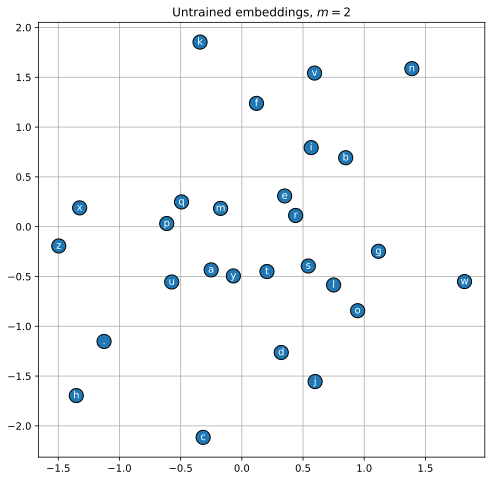

In [5]:
import torch
import string

g = torch.Generator().manual_seed(0)
C = torch.randn(27, 2, generator=g)
chars = '.' + string.ascii_lowercase

plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, zorder=3, edgecolors='black')
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), chars[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.title("Untrained embeddings, $m=2$");

Initially, the vector representation of the characters are randomly distributed in the *m*-dimensional space. This embedding will be tuned by the network so that similar characters moves closer to each other in the embedding space. Unlike in our previous model for *n*-grams which essentially learns a lookup table, this can easily represent character sequences that are out-of-distribution, i.e. those that appear very rarely in the training data. The embedding allows transfer of knowledge for different contexts by means of character similarity. This allows the model to generalize better. 

## Network architecture

We will implement the neural network shown in the following figure. First, we have the lookup table for embedding the characters. The results of the embedding are concatenated in the correct order and passed to the 2-layer MLP. Note that the weights of the MLP adjusts for ordering. The first layer applies the tanh nonlinearity. The second layer simply performs a linear operation to get the logits. 

We maximize the predict probability of the next character given the parameters of the network, which includes the parameters of the layers and the embedding table. To get the unnormalized distribution, we simply apply `.exp()` on the logits. Note that the input and output layer of the network has the same width.

```{figure} ../../img/mlp-char-level.drawio.svg
---
width: 600px
name: bigram-nn.drawio
---

Schematic diagram of our MLP neural net with embedding and block size of 3. Shown here is the input string `"ner"` that is passed first to the embedding layer, then the resulting concatenation of the embeddings are passed to the MLP with logits.
```

In [22]:
class MLP:
    def __init__(self, embedding_size, width, input_shape, seed=2147483647):
        self.width = width
        self.blk_size = input_shape[1]
        self.emb_size = embedding_size
        self._init_weights(seed)
        
    def _init_weights(self, seed):
        self.g = torch.Generator().manual_seed(seed)
        self.C0 = torch.randn(27, self.emb_size, generator=self.g)
        self.W1 = torch.randn((self.blk_size * self.emb_size, self.width), generator=self.g)
        self.b1 = torch.randn(self.width, generator=self.g)
        self.W2 = torch.randn((self.width, 27), generator=self.g)
        self.b2 = torch.randn(27, generator=self.g)
        self.parameters = [self.C0, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, xs: list[int]):
        emb = self.C0[xs].view(-1, self.blk_size * self.emb_size)
        h = torch.tanh(emb @ self.W1 + self.b1)
        logits = h @ self.W2 + self.b2
        return logits

    def zero_grad(self):
        for p in self.parameters:
           p.grad = None

    def optim_step(self, lr):
        for p in self.parameters:
           p.data -= lr * p.grad

Trying this out:

In [23]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)

model = MLP(width=100, embedding_size=2, input_shape=xs.shape)
len(xs), model(xs).shape

(68554, torch.Size([68554, 27]))

The following vector will be the input to the fully-connected layers:

In [24]:
import torch

x = xs[15]
print('x0 =', x)
print()
print('emb =\n', model.C0[x])
print()
print('x =\n', model.C0[x].view(-1, model.blk_size * model.emb_size))

x0 = tensor([ 1, 22,  1])

emb =
 tensor([[-0.0274, -1.1008],
        [-0.1158, -1.2078],
        [-0.0274, -1.1008]], grad_fn=<IndexBackward0>)

x =
 tensor([[-0.0274, -1.1008, -0.1158, -1.2078, -0.0274, -1.1008]],
       grad_fn=<ViewBackward0>)


**Remark.** Using `.view` so that the same underlying storage of the tensor is used in the computation.

### Model training

Optimizing `F.cross_entropy` loss which expects logits (unnormalized scores). This is equivalent to maximizing next character likelihood.

In [25]:
import torch.nn.functional as F

def train_model(model, xs, ys, num_steps=100, lr=0.1):
    losses = []
    for k in range(num_steps):
        logits = model(xs)
        loss = F.cross_entropy(logits, target=ys)

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if (k % (num_steps // 10) == 0) or (k == num_steps - 1):
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

    return losses


dataset = CharDataset(names, context_size=3)
xs, ys = dataset.build_dataset()
xs = torch.tensor(xs)
ys = torch.tensor(ys)

model = MLP(embedding_size=2, width=100, input_shape=xs.shape)
hist = train_model(model, xs, ys, num_steps=200, lr=0.1)

[001/200]   loss=19.4219
[021/200]   loss=8.0563
[041/200]   loss=5.5357
[061/200]   loss=4.2861
[081/200]   loss=3.6775
[101/200]   loss=3.3641
[121/200]   loss=3.1737
[141/200]   loss=3.0474
[161/200]   loss=2.9563
[181/200]   loss=2.8861
[200/200]   loss=2.8322


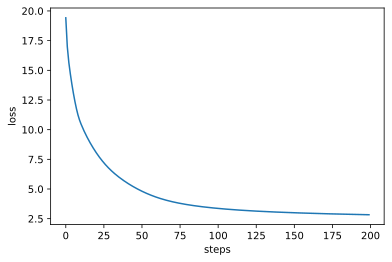

In [27]:
plt.plot(hist)
plt.ylabel('loss')
plt.xlabel('steps');

### Using mini-batch

It is crucial to use **mini-batches** to approximate the gradient. This leads to noisier and more updates, but drastically reduces the resources needed for training. Updating training function:

In [30]:
def train_model(model, xs, ys, batch_size, num_steps, lr=0.1, verbose=True, seed=42):
    losses = []
    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        
        B = torch.randint(0, xs.shape[0], (batch_size,), generator=g)        
        logits = model(xs[B])
        loss = F.cross_entropy(logits, target=ys[B])

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if verbose and ((k % (num_steps // 10) == 0) or (k == num_steps - 1)):
            print(f"[{k:>0{int(math.log10(num_steps))}d}/{num_steps}]   loss: {loss:.4f}")

    return losses


model = MLP(embedding_size=2, width=100, input_shape=xs.shape)
hist = train_model(model, xs, ys, batch_size=32, num_steps=10000, lr=0.1)

[0000/10000]   loss: 17.0046
[1000/10000]   loss: 2.6042
[2000/10000]   loss: 2.0561
[3000/10000]   loss: 2.3296
[4000/10000]   loss: 2.6371
[5000/10000]   loss: 2.2608
[6000/10000]   loss: 2.2241
[7000/10000]   loss: 2.0338
[8000/10000]   loss: 2.2408
[9000/10000]   loss: 2.4222
[9999/10000]   loss: 2.4391


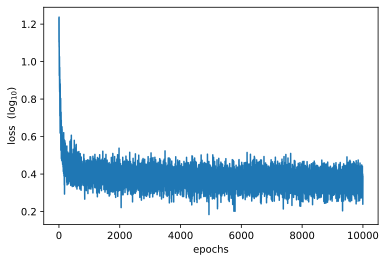

In [35]:
plt.plot(torch.tensor(hist).log10(), )
plt.xlabel("epochs")
plt.ylabel("loss  ($\log_{10}$)");

## Hyperparameters

### Finding a good base learning rate

To find a good base learning rate, we gradually increasing the learning rate linearly in its exponent, at each step in gradient descent up to the point that it destablizes. This means we start with a largest possible learning rate, then we work backwards by decreasing it using a [schedule](https://peltarion.com/knowledge-center/modeling-view/run-a-model/optimization-principles-(in-deep-learning)/learning-rate-schedule). This is an empirical heuristic that works well in practice, and is cheap to compute (i.e. compared to a nested loop which does not make sense given that we have a schedule). 

In [44]:
def find_base_lr(model, num_steps, lre_min=-3, lre_max=0, seed=42):
    """Finding a good base LR for training."""

    lre = torch.linspace(lre_min, lre_max, num_steps) # exponent of learning rate
    lrs = 10 ** lre
    batch_size = 32
    
    losses = []
    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        B = torch.randint(0, xs.shape[0], (batch_size,), generator=g)        
        logits = model(xs[B])
        loss = F.cross_entropy(logits, target=ys[B])

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lrs[k])

        # logging
        losses.append(loss.item())

    # Getting minimum of moving average (of previous losses)
    window = len(losses) // 10
    losses_ma = []
    for i in range(window, len(losses) - window):
        losses_ma.append(sum(losses[i-window:i])/window)

    plt.plot(lre, torch.tensor(losses).numpy());
    plt.ylabel('loss')
    plt.xlabel('LR exponent (base 10)');
    plt.plot(lre[:len(losses_ma)], losses_ma, label="MA 100")
    plt.legend()
    
    return 10 ** min(zip(losses_ma, lre))[1].item()
    

Note that we choose a large enough number of steps such that we observe a U-shape in the loss value:

0.1071593355657331


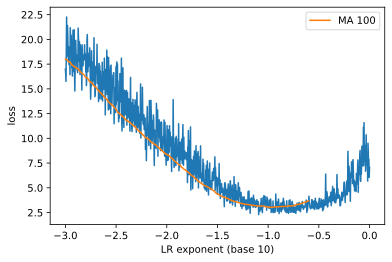

In [46]:
model = MLP(embedding_size=2, width=100, input_shape=xs.shape)
lr0 = find_base_lr(model, num_steps=1000, lre_min=-3, lre_max=0)
print(lr0)

This means that our default `0.1` is a good base learning rate for this task and model.

### Larger hidden layer

To tune the other parameters, we need to have a validation set.

In [48]:
from sklearn.model_selection import StratifiedKFold

def create_folds(xs, ys, seed=42):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    folds = torch.zeros(xs.shape[0])
    for fold, (trn_, val_) in enumerate(kf.split(xs, ys)):
        folds[val_] = fold

    xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
    xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
    xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

    return xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst


def cross_entropy_loss(model, xs, ys):
    return F.cross_entropy(model(xs), ys)


def train_model(
        model, 
        xs, ys, 
        xs_dev, ys_dev, 
        batch_size,
        num_steps,
        loss_fn=cross_entropy_loss,
        lr=0.1,
        eval_fn=None,
        verbose=True,
        seed=42
    ):
    
    if eval_fn is None:
        eval_fn = loss_fn

    losses_trn = {}
    losses_dev = {}

    g = torch.Generator().manual_seed(seed)
    for k in range(num_steps):
        lr_step = lr if k < 0.5 * num_steps else 0.1 * lr

        B = torch.randint(0, xs.shape[0], (batch_size,), generator=g)        
        logits = model(xs[B])
        loss = F.cross_entropy(logits, target=ys[B])

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr_step)

        # logging
        losses_trn[k] = loss.item()
        if (k % (num_steps // 10) == 0) or (k == num_steps - 1):
            with torch.no_grad():
                loss_dev = eval_fn(model, xs_dev, ys_dev)
                losses_dev[k] = loss_dev.item()

            if verbose:
                print(f"[{k:>0{int(math.log10(num_steps))}d}/{num_steps}]    loss={loss:.4f}    dev_loss={loss_dev:.4f}")
    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev}

Splitting and finding 

[00000/100000]    loss=18.8847    dev_loss=15.7449
[10000/100000]    loss=2.1247    dev_loss=2.4096
[20000/100000]    loss=2.6863    dev_loss=2.2586
[30000/100000]    loss=2.0545    dev_loss=2.2711
[40000/100000]    loss=2.2072    dev_loss=2.2280
[50000/100000]    loss=2.6671    dev_loss=2.1948
[60000/100000]    loss=2.1854    dev_loss=2.0686
[70000/100000]    loss=2.0218    dev_loss=2.0661
[80000/100000]    loss=1.6800    dev_loss=2.0549
[90000/100000]    loss=1.8537    dev_loss=2.0647


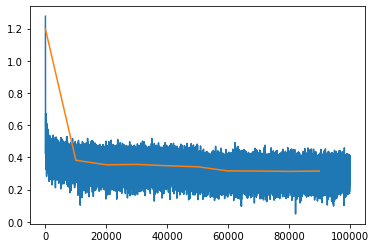

In [30]:
xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst = create_folds(xs, ys)
model = MLP(100, embedding_size=2, input_shape=xs.shape)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=100000, lr=lr0)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10());
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10());

[00000/200000]    loss=65.2649    dev_loss=46.2628
[20000/200000]    loss=3.3858    dev_loss=2.8789
[40000/200000]    loss=2.3749    dev_loss=2.5920
[60000/200000]    loss=2.3675    dev_loss=2.4025
[80000/200000]    loss=1.8411    dev_loss=2.2886
[100000/200000]    loss=1.9513    dev_loss=2.2077
[120000/200000]    loss=2.5784    dev_loss=2.0735
[140000/200000]    loss=2.2495    dev_loss=2.0771
[160000/200000]    loss=2.2463    dev_loss=2.0720
[180000/200000]    loss=1.9862    dev_loss=2.0663


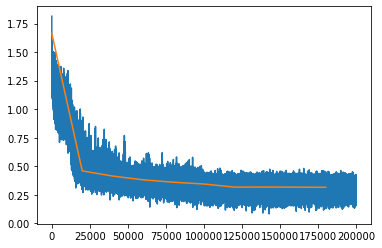

In [31]:
xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst = create_folds(xs, ys)
model = MLP(1000, 2, xs.shape)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=lr0)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10());
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10());

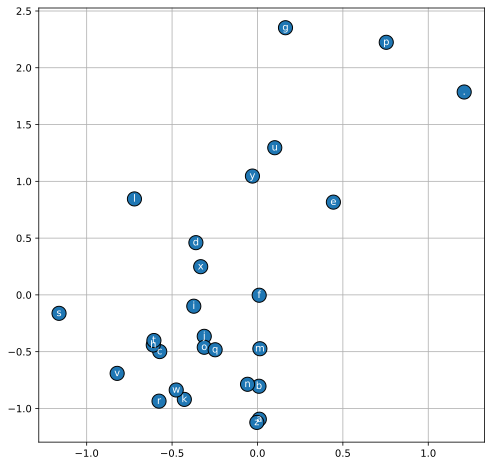

In [109]:
plt.figure(figsize=(8, 8))
plt.scatter(model.C0[:, 0].data, model.C0[:, 1].data, s=200, edgecolors='black', zorder=3)
for i in range(model.C0.shape[0]):
    plt.text(model.C0[i, 0].item(), model.C0[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Checking for bottleneck embedding size

[00000/200000]    loss=25.3745    dev_loss=24.5328
[20000/200000]    loss=2.4965    dev_loss=2.2906
[40000/200000]    loss=1.8341    dev_loss=2.2518
[60000/200000]    loss=2.0731    dev_loss=2.2004
[80000/200000]    loss=1.6896    dev_loss=2.2120
[100000/200000]    loss=1.6425    dev_loss=2.1738
[120000/200000]    loss=2.4527    dev_loss=2.0072
[140000/200000]    loss=1.8954    dev_loss=2.0123
[160000/200000]    loss=1.9332    dev_loss=2.0145
[180000/200000]    loss=1.6902    dev_loss=2.0130


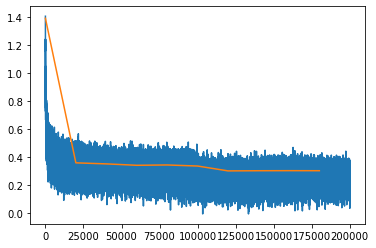

In [33]:
xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst = create_folds(xs, ys)
model = MLP(200, 10, xs.shape)
hist = train_model(model, xs_trn, ys_trn, xs_dev, ys_dev, batch_size=32, num_steps=200000, lr=0.5*lr0)

plt.plot(hist['loss_trn'].keys(), torch.tensor(list(hist['loss_trn'].values())).log10());
plt.plot(hist['loss_dev'].keys(), torch.tensor(list(hist['loss_dev'].values())).log10());

In [34]:
def generate_names(model, context_size, sample_size, seed=2147483647):
    """Generate names from a Markov process with cond probability table P."""

    g = torch.Generator().manual_seed(seed)
    names = []
    for _ in range(sample_size):
        out = []
        context = [0] * context_size
        while True:
            p = model(torch.tensor(context)).exp()
            j = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            if j == 0:
                break
            context = context[1:] + [j]
            out.append(itos[j])
        names.append(''.join(out))
    return names

## Computing the test performance

In [35]:
F.cross_entropy(model(xs_tst), ys_tst)

tensor(2.0097, grad_fn=<NllLossBackward0>)

## Sampling

In [36]:
def name_loss(name, context_size, model):
    nll = 0.0
    context = [0] * context_size
    for c in name + '.':
        p = F.softmax(model(torch.tensor(context))).reshape(-1)[stoi[c]]
        nll += -math.log(p)
        context = context[1:] + [stoi[c]]
    return nll / (len(name) + 1)


sample = generate_names(model, 3, sample_size=12)
name_losses = {n: name_loss(n, 3, model) for n in sample}
for n in sorted(sample, key=lambda n: name_losses[n]):
    print(f"{n:<22} {name_losses[n]:.3f}")


jaquelynn              1.151
tyanna                 1.392
mira                   1.393
toveya                 1.681
magi                   1.753
rammie                 1.972
alva                   1.997
ahlissa                1.999
aarlisely              2.009
landelesmaebrimie      2.057
oma                    2.732
aldai                  2.955


## Appendix: Exercises

Exercises:
- E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
- E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?
- E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

